In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

# Exploratory Climate Analysis

In [11]:
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns2 = inspector.get_columns('Station')
for c2 in columns2:
    print(c2['name'], c2['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


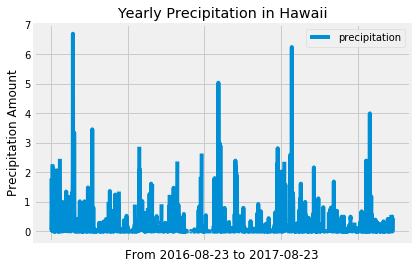

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(last_date)
year_past = dt.date(2017,8,23) - dt.timedelta(days=365)
#print(year_past)

# last date is 2017/08/23 and 12 months before date is 2016/08/23

# Perform a query to retrieve the data and precipitation scores
precipitation_last_12months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-22').all()
# print(precipitation_last_12months)
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_last_12months)
precipitation_df = precipitation_df.set_index('date').rename(columns={'prcp':'precipitation'})

precipitation_df.head()

# Sort the dataframe by date
precipitation_df_sorted = precipitation_df.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data

prcp_one_year_graph = precipitation_df_sorted.plot(y='precipitation', use_index=True)
prcp_one_year_graph.set_title("Yearly Precipitation in Hawaii")
prcp_one_year_graph.set_ylabel('Precipitation Amount')
prcp_one_year_graph.set_xlabel('From 2016-08-23 to 2017-08-23')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement).group_by(Measurement.station).count()
print(f'There are {stations_count} stations in Hawaii')

There are 9 stations in Hawaii


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_df = pd.DataFrame(most_active)
most_active_df


,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_record_most_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active[0][0]).all()
temp_record_most_active_station

[(54.0, 85.0, 71.66378066378067)]

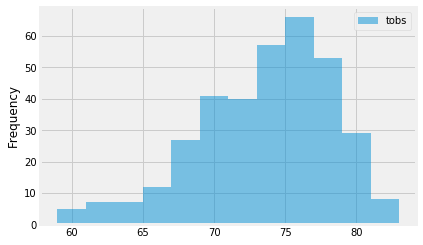

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp_obs = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(Measurement.station == most_active[0][0]).filter(Measurement.date >= year_past).all()
highest_temp_obs_df = pd.DataFrame(highest_temp_obs)
temp_graph = highest_temp_obs_df.plot.hist(by='station', bins=12, alpha=0.5)
plt.show()


In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
myVaca_temp = calc_temps('2016-12-18', '2016-12-29')
tmin_myVaca = calc_temps('2016-12-18', '2016-12-29')[0][0]
tavg_myVaca = calc_temps('2016-12-18', '2016-12-29')[0][1]
tmax_myVaca = calc_temps('2016-12-18', '2016-12-29')[0][2]



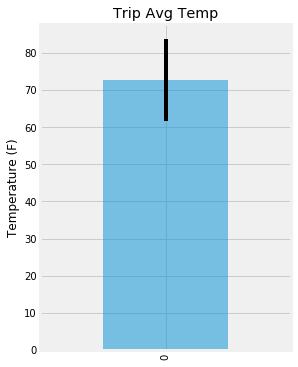

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

myVaca_tmp_df = pd.DataFrame(myVaca_temp, columns = ['Min Temp', 'Avg Temp', 'Max Temp'])
avg_tmp_df = myVaca_tmp_df['Avg Temp']

avg_tmp_df.plot(kind='bar', yerr = (tmax_myVaca - tmin_myVaca), figsize=(4,6), alpha=0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.show()

In [24]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

tobs_per_station = session.query(Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-12-18').filter(Measurement.date <= '2016-12-29').all()
tobs_per_station_df = pd.DataFrame(tobs_per_station)
tobs_per_station_df = tobs_per_station_df.groupby(['station'], as_index=False).sum()
tobs_per_station_df = tobs_per_station_df.sort_values(by = ['prcp'], ascending=False)
tobs_per_station_df = tobs_per_station_df.reset_index(drop=True)

station_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_info_df = pd.DataFrame(station_info)

vaca_info = tobs_per_station_df.join(station_info_df.set_index('station'), on='station')
vaca_info

,station,prcp,name,latitude,longitude,elevation
0,USC00516128,7.02,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,2.50,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,1.55,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,0.93,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519523,0.75,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.25,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,0.06,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
vaca_start_date = '2016-12-18'
vaca_end_date = '2016-12-29'

# Use the start and end date to create a range of dates
vaca_days = session.query(Measurement.date).filter(Measurement.date >= vaca_start_date).filter(Measurement.date <= vaca_end_date).group_by(Measurement.date).all()
dates = [x[0] for x in vaca_days]

# Stip off the year and save a list of %m-%d strings
dates_no_year = [x[5:] for x in dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(i) for i in dates_no_year]

normals = [x[0] for x in normals]




In [38]:
dates_df = pd.to_datetime(dates)
dates_df

DatetimeIndex(['2016-12-18', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29'],
              dtype='datetime64[ns]', freq=None)

In [44]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['Min Temp', 'Avg Temp', 'Max Temp'])
normals_df['dates'] = dates_df
normals_df = normals_df.set_index('dates', drop=True)
normals_df

,Min Temp,Avg Temp,Max Temp
dates,,,
2016-12-18,63.0,71.280000,77.0
2016-12-19,67.0,72.000000,78.0
2016-12-20,65.0,72.913043,81.0
2016-12-21,67.0,72.139535,78.0
2016-12-22,67.0,71.130435,77.0
2016-12-23,61.0,70.346939,78.0
2016-12-24,62.0,70.062500,78.0
2016-12-25,60.0,71.750000,79.0
2016-12-26,63.0,71.446809,77.0


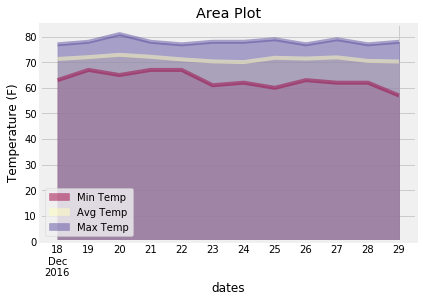

In [47]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, alpha=0.5, colormap='Spectral', title='Area Plot')
plt.ylabel("Temperature (F)")
plt.show()